#Notebook 01 Objective:
Load customer_information.csv, clean it, run some basic EDA, and save a processed file for downstream ML.

#customer_information.csv README.md
### Customer information

* File name: customer_information.csv

* Description: Detailed information about the customers. NOTE: A customer might appear here several times (with different dates, as their information might have been updated)

* Columns:
    - customerID: Customer identifier.
    - customerType: Type of the customer. It can have the following values:
        - Mass: Majority of customers. Less than 60k euros on investments.
        - Premium: Individual investor. More than 60k euros on investments.
        - Professional: Sole proprietorship. Individual customer that exercises his financial activity without having created a legal person.
        - Legal entity: legal entities with services within the bank.
        - Inactive: Customers that cannot be identified in the previous categories.
    - riskLevel: Risk tolerance of the customer. Levels, from lower to higher risk:
        - Conservative
        - Income
        - Balanced
        - Aggressive
        - Predicted_Conservative / Predicted_Income / Predicted_Balanced / Predicted_Aggressive: Same as earlier, but predicted by an algorithm.
        - Not_Available: Not available data.
    - investmentCapacity: Amount of money that the customer might invest. Possible values:
        - CAP_LT_30K: Less than 30K euros.
        - CAP_30K_80K: Between 30K and 80K euros.
        - CAP_80K_300K: Between 80K and 300K euros.
        - CAP_GT300K: More than 300K euros.
        - Predicted_CAP_LT_30K / Predicted_CAP_30K_80K / Predicted_CAP_80K_300K / Predicted_GT300K: Same as earlier, but predicted by an algorithm.
        - Not_Available: Not available data.
    - lastQuestionnaireDate: Date where the risk questionnaire was last completed.
- timestamp: Timestamp of last update.


In [ ]:
# Cell 1 — Setup, imports & load FAR data
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# --- Base paths ---
BASE_DIR = "/content/drive/MyDrive/portfoliai"
RAW_DIR = f"{BASE_DIR}/data/raw"
PROC_DIR = f"{BASE_DIR}/data/processed"
os.makedirs(PROC_DIR, exist_ok=True)

print("✅ Directories ready.")

# --- Load FAR customer information ---
far_customers = pd.read_csv(f"{RAW_DIR}/customer_information.csv")
print("✅ FAR customer data loaded. Shape:", far_customers.shape)

display(far_customers.head())


Mounted at /content/drive
✅ Directories ready.
✅ FAR customer data loaded. Shape: (32468, 6)


,customerID,customerType,riskLevel,investmentCapacity,lastQuestionnaireDate,timestamp
0,DED5BF19E23CCCFEE322,Premium,Balanced,CAP_80K_300K,2021-11-30,2021-03-19
1,DED5BF19E23CCCFEE322,Premium,Balanced,CAP_80K_300K,2021-11-30,2022-01-21
2,6C0C752E66D5F0486C71,Mass,Income,Predicted_CAP_LT30K,2015-04-27,2018-01-02
3,3E8D8E4E07CD3210F25F,Mass,Income,CAP_30K_80K,2021-11-03,2018-01-02
4,37F996EE2A69B5C15DF3,Mass,Predicted_Conservative,Predicted_CAP_LT30K,2000-01-01,2018-01-02


In [ ]:
# Cell 2 — Basic EDA (FAR only)
display(far_customers.describe(include="all"))
print("Missing values:\n", far_customers.isna().sum())


,customerID,customerType,riskLevel,investmentCapacity,lastQuestionnaireDate,timestamp
count,32468,32468,32468,32468,32468,32468
unique,29090,5,9,9,1555,1167
top,26FE717B0D0ABFEF14B9,Mass,Income,CAP_LT30K,2000-01-01,2018-01-02
freq,9,19810,10048,14030,7275,15752


Missing values:
 customerID               0
customerType             0
riskLevel                0
investmentCapacity       0
lastQuestionnaireDate    0
timestamp                0
dtype: int64


In [ ]:
# Cell 3 — Chi-square tests (categorical features vs riskLevel)
categorical_cols_far = ["customerType", "investmentCapacity"]
target_far = "riskLevel"

for col in categorical_cols_far:
    ct = pd.crosstab(far_customers[col], far_customers[target_far])
    chi2, p, dof, _ = stats.chi2_contingency(ct)
    print(f"\n▶ {col} vs {target_far} — χ²={chi2:.2f}, p={p:.4f}")



▶ customerType vs riskLevel — χ²=6015.91, p=0.0000

▶ investmentCapacity vs riskLevel — χ²=68650.03, p=0.0000


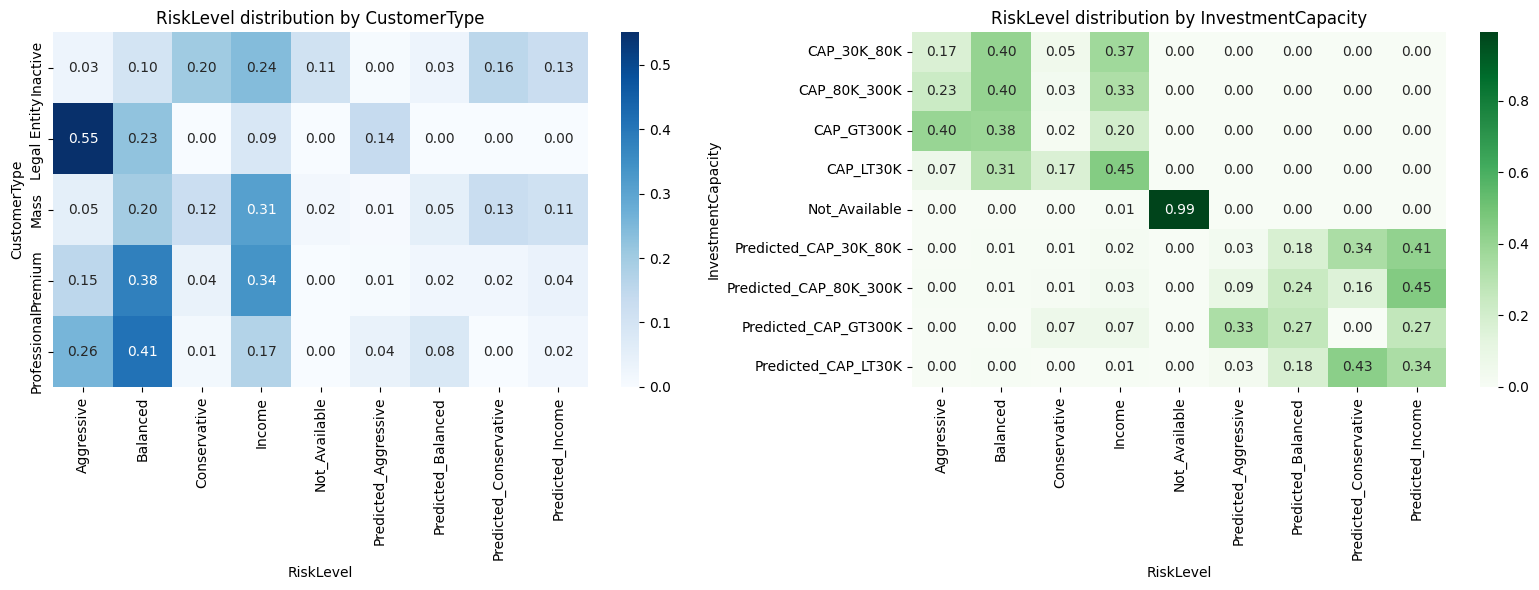

In [ ]:
# Cell 3b — Heatmaps: Relationship between Risk Level and Categorical Features

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Crosstab: customerType vs riskLevel
ct1 = pd.crosstab(far_customers["customerType"], far_customers["riskLevel"], normalize="index")
sns.heatmap(ct1, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title("RiskLevel distribution by CustomerType")
axes[0].set_ylabel("CustomerType")
axes[0].set_xlabel("RiskLevel")

# Crosstab: investmentCapacity vs riskLevel
ct2 = pd.crosstab(far_customers["investmentCapacity"], far_customers["riskLevel"], normalize="index")
sns.heatmap(ct2, annot=True, fmt=".2f", cmap="Greens", ax=axes[1])
axes[1].set_title("RiskLevel distribution by InvestmentCapacity")
axes[1].set_ylabel("InvestmentCapacity")
axes[1].set_xlabel("RiskLevel")

plt.tight_layout()
plt.show()


##customerType vs riskLevel

χ² = 6015.91 (very large)

p = 0.0000 (essentially < 1e-10)

✅ Interpretation: There is an extremely strong relationship between customer type (Mass, Premium, Professional, etc.) and risk tolerance (Conservative, Balanced, Aggressive).


##investmentCapacity vs riskLevel

χ² = 68650.03 (enormous)

p = 0.0000

✅ Interpretation: Investment capacity (CAP_LT_30K, CAP_30K_80K, etc.) is very strongly related to risk tolerance.

The test shows that who the customer is (customerType) and how much money they can invest (investmentCapacity) are not random with respect to risk profile — they’re tightly linked.

In [ ]:
# Cell 4 — Kruskal-Wallis tests (numeric features, if any)
numeric_cols_far = []  # currently no numeric features beyond capacity buckets

for col in numeric_cols_far:
    groups = [g[col].dropna().values for _, g in far_customers.groupby(target_far)]
    H, p = stats.kruskal(*groups)
    print(f"▶ {col} vs {target_far}: H={H:.2f}, p={p:.4e}")


In [ ]:
# Cell 4a — Clean target variable (riskLevel)
far_customers["riskLevel_clean"] = (
    far_customers["riskLevel"]
    .str.replace("Predicted_", "", regex=False)
    .replace("Not_Available", np.nan)
)

print("Unique values in cleaned riskLevel:", far_customers["riskLevel_clean"].unique())

# Drop rows without a valid risk level
far_customers = far_customers.dropna(subset=["riskLevel_clean"])
print("✅ Dropped rows with missing/Not_Available riskLevel.")
print("Remaining shape:", far_customers.shape)


Unique values in cleaned riskLevel: ['Balanced' 'Income' 'Conservative' 'Aggressive' nan]
✅ Dropped rows with missing/Not_Available riskLevel.
Remaining shape: (32124, 7)


In [1]:
# Cell 4b — Clean + Encode categorical features

from sklearn.preprocessing import LabelEncoder

# 1) Clean investmentCapacity (remove Predicted_, map Not_Available → NaN)
far_customers["investmentCapacity_clean"] = (
    far_customers["investmentCapacity"]
    .str.replace("Predicted_", "", regex=False)
    .replace("Not_Available", np.nan)
)

print("Unique investmentCapacity values (clean):")
print(far_customers["investmentCapacity_clean"].unique())

# 2) Encode customerType
le_ct = LabelEncoder()
far_customers["customerType_enc"] = le_ct.fit_transform(far_customers["customerType"])

# 3) Encode cleaned investmentCapacity (fill missing with 'Unknown' for now)
le_ic = LabelEncoder()
far_customers["investmentCapacity_enc"] = le_ic.fit_transform(
    far_customers["investmentCapacity_clean"].fillna("Unknown")
)

# 4) Preview
display(
    far_customers[[
        "customerType", "customerType_enc",
        "investmentCapacity_clean", "investmentCapacity_enc",
        "riskLevel_clean"
    ]].head(10)
)


NameError: name 'far_customers' is not defined

🔎 Summary of Cell 4b

In this step, we cleaned and encoded categorical features for feature discovery:

Removed the "Predicted_" prefix from investmentCapacity and mapped "Not_Available" to NaN.

Created a new column investmentCapacity_clean with only valid capacity buckets (CAP_LT30K, CAP_30K_80K, CAP_80K_300K, CAP_GT300K).

Encoded both customerType and investmentCapacity_clean into numeric codes using LabelEncoder.

Kept the original text labels alongside the numeric codes for easy interpretation.

👉 This ensures we have clean, consistent categories that can be used for modeling in Notebook 2.

In [ ]:
# Cell 5 — Save processed FAR subset
out_path = f"{PROC_DIR}/far_customers_clean.csv"
far_customers.to_csv(out_path, index=False)
print("💾 Saved processed FAR customers at:", out_path)


💾 Saved processed FAR customers at: /content/drive/MyDrive/portfoliai/data/processed/far_customers_clean.csv
